### Random Forests and Gradient Boosted Regression Trees

Fundamentals of fitting random forests and GBRT. These involve out-of-bound estmates and cross-validation, and how you might want to deal with hyperparameters in these models. 

Jay Urbain, PhD


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
# pd.set_option('display.width', 500)
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.notebook_repr_html', True)
#import seaborn.apionly as sns
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#### Dataset

The California housing prices dataset is built into sklearn. The data is quite skewed as we shall see.

In [71]:
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()

In [72]:
cal_housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# split 80/20 train-test
Xtrain, Xtest, ytrain, ytest = train_test_split(cal_housing.data,
                                                    cal_housing.target,
                                                    test_size=0.2)
names = cal_housing.feature_names

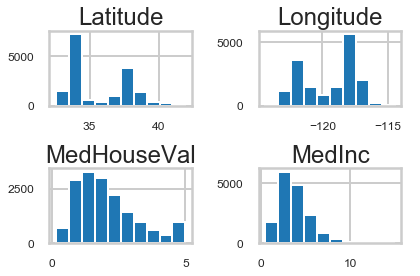

In [24]:
df = pd.DataFrame(data=Xtrain, columns=names)
df['MedHouseVal'] = ytrain
m = df.hist(column=['Latitude', 'Longitude', 'MedInc', 'MedHouseVal'], xlabelsize=12, ylabelsize=12)
plt.tight_layout()

Notice the high bump in the median house value. why do you think that is? How might you model it?

In [25]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,1.3417,33.0,4.421801,1.037915,838.0,3.971564,34.12,-117.33,0.690
1,4.6197,21.0,3.701933,1.019329,1489.0,1.514751,34.05,-118.46,3.875
2,7.1687,22.0,7.615721,0.986900,1479.0,3.229258,34.46,-119.81,3.844
3,3.9545,26.0,5.877729,1.027656,2065.0,3.005822,32.75,-117.01,1.781
4,5.8362,32.0,6.511029,1.088235,995.0,3.658088,33.77,-118.01,2.175


In [26]:
df.shape

(16512, 9)

#### General Trees

Simple Decision Tree regressor model without any cross-validation or regularization.

This is what you ought to keep in mind about decision trees:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

In [27]:
from sklearn.tree import DecisionTreeRegressor
x = np.arange(0, 2*np.pi, 0.1)
y = np.sin(x) + 0.1*np.random.normal(size=x.shape[0])

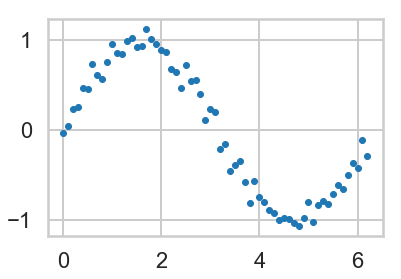

In [28]:
plt.plot(x,y, '.');

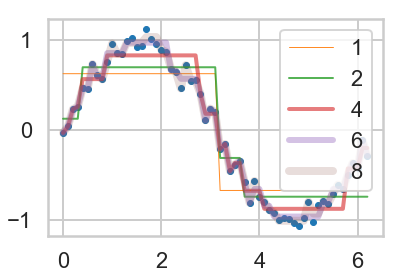

In [29]:
plt.plot(x,y,'.')
xx = x.reshape(-1,1)
for i in [1,2,4,6,8]:
    dtsin = DecisionTreeRegressor(max_depth=i)
    dtsin.fit(xx, y)
    plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
plt.legend();

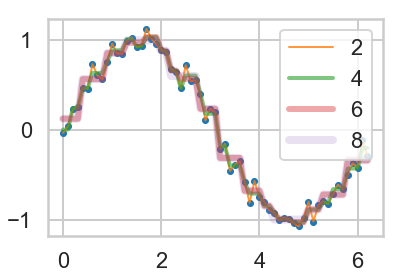

In [30]:
plt.plot(x,y,'.')
xx = x.reshape(-1,1)
for i in [2,4,6,8]:
    dtsin = DecisionTreeRegressor(min_samples_split=i)
    dtsin.fit(xx, y)
    plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
plt.legend();

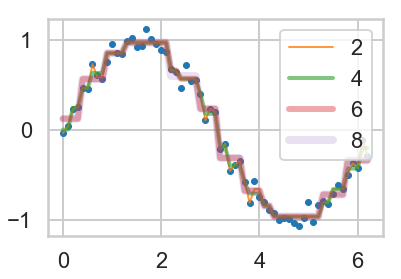

In [31]:
plt.plot(x,y,'.')
xx = x.reshape(-1,1)
for i in [2,4,6,8]:
    dtsin = DecisionTreeRegressor(max_depth=6, min_samples_split=i)
    dtsin.fit(xx, y)
    plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
plt.legend();

Ok with this discussion in mind, lets approach Random Forests.

#### Random Forests

Whats the basic idea?

- Decision trees overfit, do not capture overlapping decision spaces.
- Introduce ensemble models with randomization.
- Randomization 1: Use bootstrap resampling to create different training datasets. This way each training will give us a different tree and the robust aspects of the regression will remain.
- Added advantage is that the left out points can be used to "validate"
- Can choose a large `max_depth`

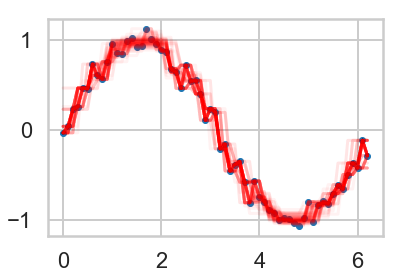

In [32]:
plt.plot(x,y,'.')
for i in range(100):
    dtsin = DecisionTreeRegressor(max_depth=6)
    isamp = np.random.choice(range(x.shape[0]), replace=True, size=x.shape[0])
    xx = x[isamp].reshape(-1,1)
    dtsin.fit(xx, y[isamp])
    plt.plot(x, dtsin.predict(x.reshape(-1,1)), 'r', alpha=0.05)

This is not enough randomization, because even after bootstrapping, you are mainly training on the same data points, those that appear more often, and will retain some overfitting.

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
# code from 
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
from collections import OrderedDict
param_dict = OrderedDict(
    n_estimators = [400, 600, 800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

param_dict.values()

odict_values([[400, 600, 800], [0.2, 0.4, 0.6, 0.8]])

Here we create a Param Grid. We are preparing to use the bootstrap points not used to validate.

```
max_features : int, float, string or None, optional (default=”auto”)
The number of features to consider when looking for the best split.
```

- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 
- You can "validate" on the trees `n_estimators` as well but many a times you will just look for the plateau in the trees as seen below.
- From decision trees you get the `max_depth`, `min_samples_split`, and `min_samples_leaf` as well but you might as well leave those at defaults to get a maximally expanded tree.

### Using the OOB score.

We have been putting "validate" in quotes. This is because the bootstrap gives us left-over points! So we'll now engage in our very own version of a grid-search, done over the out-of-bag scores that `sklearn` gives us for free

In [35]:
from itertools import product

In [36]:
results = {}
estimators= {}
for n, f in product(*param_dict.values()):
    params = (n, f)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=n, max_features=f, n_jobs=-1)
    est.fit(Xtrain, ytrain)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(600, 0.4)

In [37]:
rf1 = estimators[outparams]

In [38]:
results

{(400, 0.2): 0.7907609860096728,
 (400, 0.4): 0.8210086019848557,
 (400, 0.6): 0.8178496336339932,
 (400, 0.8): 0.8131766997520994,
 (600, 0.2): 0.7903569366706189,
 (600, 0.4): 0.823147873278451,
 (600, 0.6): 0.8179552065455717,
 (600, 0.8): 0.8134727081418065,
 (800, 0.2): 0.7905217117714614,
 (800, 0.4): 0.8220987410151464,
 (800, 0.6): 0.8194964092649053,
 (800, 0.8): 0.8143492573991833}

In [39]:
rf1.score(Xtest, ytest)

0.8241962623103339

Since our response is very skewed, we may want to suppress outliers by using the `mean_absolute_error` instead. 

In [40]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, rf1.predict(Xtest))

0.3199956949788857

`sklearn` supports this (`criterion='mae'`) since 0.18, but does not have arbitrary loss functions for Random Forests.

YOUR TURN NOW
>Lets try this with MAE

In [41]:
# your code here

Finally you can get feature importances. Whenever a feature is used in a tree in the forest, the algorithm will log the decrease in the splitting criterion such as gini. This is accumulated over all trees and reported in `est.feature_importances_`

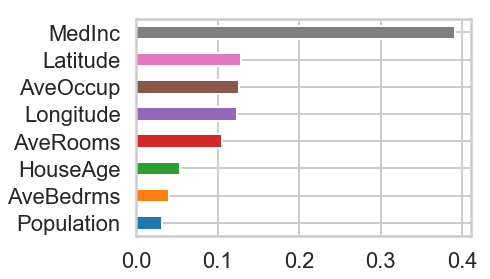

In [42]:
pd.Series(rf1.feature_importances_, index=names).sort_values().plot(kind="barh")

You can do cross-validation if you want, and a cv of 3 will roughly be comparable. But this will take much more time as you are doing the fit 3 times plus the bootstraps. So atleast three times as long!

In [43]:
param_dict2 = OrderedDict(
    n_estimators = [600],
    max_features = [0.2, 0.4, 0.6]
)

In [44]:
from sklearn.model_selection import GridSearchCV
est2 = RandomForestRegressor(oob_score=False)
gs = GridSearchCV(est2, param_grid = param_dict2, cv=3, n_jobs=-1)
gs.fit(Xtrain, ytrain)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=OrderedDict([('n_estimators', [600]), ('max_features', [0.2, 0.4, 0.6])]),
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
rf2 = gs.best_estimator_
rf2

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [46]:
gs.best_score_

0.8139378842460979

How would you support scoring using mean absolute error if you use cross-validation?

### Seeing error as a function of the number of trees

We can instead, of different `max_features` see how performance varies across the number of trees one uses:

In [47]:
# from http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

feats = param_dict['max_features']
# 
error_rate = OrderedDict((label, []) for label in feats)

# Range of `n_estimators` values to explore.
min_estimators = 200
step_estimators = 200
num_steps = 3
max_estimators = min_estimators + step_estimators*num_steps
for label in feats:
    for i in range(min_estimators, max_estimators+1, step_estimators):
        clf = RandomForestRegressor(oob_score=True, max_features=label)
        clf.set_params(n_estimators=i)
        clf.fit(Xtrain, ytrain)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

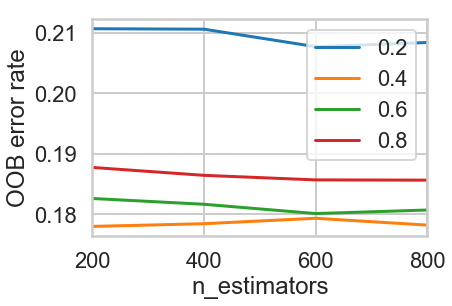

In [48]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## Gradient Boosted Regression Trees

Adaboost Classification, which you will be doing in your homework, is a special case of a gradient-boosted algorithm. Gradient Bossting is very state of the art, and has major connections to logistic regression, gradient descent in a functional space, and search in information space. See Shapire and Freund's MIT Press book for details.

But briefly, let us cover the idea here. The idea is that we will use a bunch of weak learners and fit sequentially. The first one fits the signal, the second one the first residual, the third the second residual and so on. At each stage we upweight the places that our previous learner did badly on. First let us illustrate.

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
estgb = GradientBoostingRegressor(n_estimators=500, max_depth=1, learning_rate=1.0)
estgb.fit(x.reshape(-1,1), y)
staged_predict_generator = estgb.staged_predict(x.reshape(-1,1))

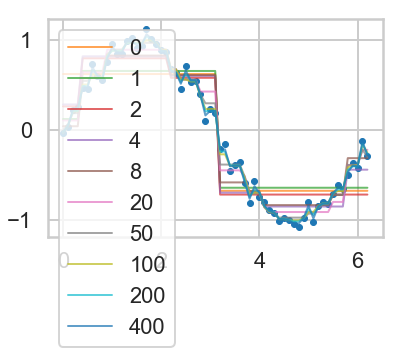

In [50]:
# code from http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb
import time
from IPython import display
plt.plot(x, y, '.');
i = 0 
counter = 0
for stagepred in staged_predict_generator:
    if i in [0, 1, 2, 4, 8, 20, 50, 100, 200, 400, 500]:
        plt.plot(x, stagepred, alpha=0.7, label=str(i), lw=2)
        plt.legend();
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(2 - counter*0.1)
        counter = counter + 1
    i = i + 1

Ok, so this demonstration helps us understand some things about GBRT.

- `n_estimators` is the number of trees, and thus the stage in the fitting. It also controls the complexity for us. The more trees we have the more we fit to the tiny details.
- `staged_predict` gives us the prediction at each step
- once again `max_depth` from the underlying decision tree tells us the depth of the tree. But here it tells us the amount of features interactions we have, not just the scale of our fit. But clearly it increases the variance again.

Ideas from decision trees remain. For example, increase `min_samples_leaf` to increase the bias.

YOUR TURN NOW

>Demonstrate what happens when you increase `max_depth` to 5

In [51]:
# your code here

YOUR TURN NOW

> What happens if you put `max_depth` back to 1 and decrease the learning rate to 0.1?

In [52]:
# your code here

### Whats the relationship between residuals and the gradient?

Pavlos showed in class that for the squared loss, taking the gradient in the "data point functional space", ie a N-d space for N data points with each variable being $f(x_i)$ just gives us the residuals. It turns out that the gradient descent is the more general idea, and one can use this for different losses. And the upweighting of poorly fit points in AdaBoost is simply a weighing by gradient. If the gradient (or residual) is high it means you are far away from optimum in this functional space, and if you are at 0, you have a flat gradient!

The ideas from the general theory of gradient descent tell us this: we can slow the learning by shrinking the predictions of each tree by some small number, which is called the learning_rate (learning_rate). This "shrinkage" helps us not overshoot, but for a finite number of iterations also simultaneously ensures we dont overfit by being in the neighboorhood of the minimum rather than just at it! But we might need to increase the iterations some to get into the minimum area.

### Ok, so how to do the fit?

In [53]:
gb = GradientBoostingRegressor(n_estimators=1000, max_depth=5)
gb.fit(Xtrain, ytrain)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

A deviance plot can be used to compare train and test errors against the number of iterations.

- Training error (deviance, related to the KL-divergence) is stored in `est.train_score_`
- Test error is computed using `est.staged_predict` (this uses `est.loss_`)

In [54]:
def deviance_plot(est, X_test, y_test, ax=None, label='', train_color='#2c7bb6', 
                  test_color='#d7191c', alpha=1.0, ylim=(0, 10)):
    """Deviance plot for ``est``, use ``X_test`` and ``y_test`` for test error. """
    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
       test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
        
    ax.plot(np.arange(n_estimators) + 1, test_dev, color=test_color, label='Test %s' % label, 
             linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color=train_color, 
             label='Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

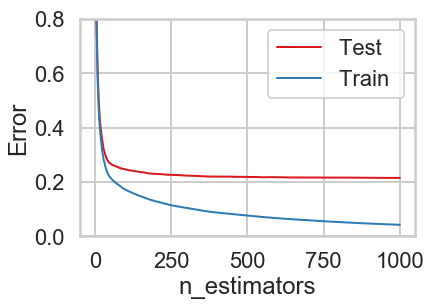

In [55]:
deviance_plot(gb, Xtest, ytest, ylim=(0,0.8));
plt.legend();

Notice the wide gap. This is an indication of overfitting!

Unlike random forests, where we are using the randomness to our benefits, the GBRT requires careful cross-validation

Peter Prettenhofer, who wrote sklearns GBRT implementation writes in his pydata14 talk (worth watching!)

>Hyperparameter tuning
I usually follow this recipe to tune the hyperparameters:

>- Pick n_estimators as large as (computationally) possible (e.g. 3000)
- Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search
- A lower learning_rate requires a higher number of n_estimators. Thus increase n_estimators even more and tune learning_rate again holding the other parameters fixed

This last point is a tradeof between number of iterations or runtime against accuracy. And keep in mind that it might lead to overfitting.

Let me add however, that poor learners do rather well. So you might want to not cross-validate `max_depth`. And `min_samples_per_leaf` is not independent either, so if you do use cross-val, you might just use one of those.

### Cross Validation with Huber Loss

The Huber Loss may be used to deal with outliers. Here is a diagram from Cornell's CS4780:

![](http://www.cs.cornell.edu/courses/cs4780/2015fa/web/lecturenotes/pngPic/c4/regressionlosses.png)

In [56]:
param_grid = {'learning_rate': [0.1, 0.01],
              'max_depth': [3, 6],
              'min_samples_leaf': [3, 5],  ## depends on the num of training examples
              'max_features': [0.2, 0.6]
              }

In [57]:
gb = GradientBoostingRegressor(n_estimators=600, loss='huber')
gb_cv = GridSearchCV(gb, param_grid, cv=3, n_jobs=-1)

This will take some time! We've made a smaller grid, but things are still slow

In [58]:
gb_cv.fit(Xtrain, ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_sa...       subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 6], 'min_samples_leaf': [3, 5], 'max_features': [0.2, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
gb_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=6,
             max_features=0.6, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=600,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

We get a slightly better MAE than Random Forest, even though the model scoring was done on mean squared error. There is a price to be paid, however, time costly cross-validation.

Notice that the criterion on the splits uses a specific MSE, and we did not score on cross-validation by another loss, simply using MSE.

In [60]:
mean_absolute_error(ytest, gb_cv.predict(Xtest))

0.28738083017591115

And the deviance plot shows a huge narrowing of the gap!

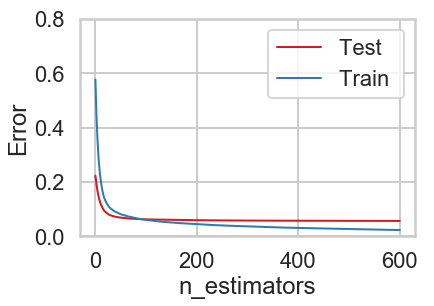

In [61]:
deviance_plot(gb_cv.best_estimator_, Xtest, ytest, ylim=(0,0.8));
plt.legend();

In [62]:
bp = gb_cv.best_params_
bp

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 0.6,
 'min_samples_leaf': 5}

We can now play with the number of iterations and the learning rate.

In [63]:
param_grid2 = {'learning_rate': [0.1, 0.01, 0.001]}

In [64]:
gb2 = GradientBoostingRegressor(n_estimators=1000, 
                                loss="huber", 
                                max_depth=bp['max_depth'],
                                max_features=bp['max_features'],
                                min_samples_leaf=bp['min_samples_leaf'])

In [65]:
gb2_cv = GridSearchCV(gb2, param_grid2, cv=3, n_jobs=-1)

In [66]:
gb2_cv.fit(Xtrain, ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=6,
             max_features=0.6, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_sam...       subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [67]:
gb2_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=6,
             max_features=0.6, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [68]:
mean_absolute_error(ytest, gb2_cv.predict(Xtest))

0.28849122805716215

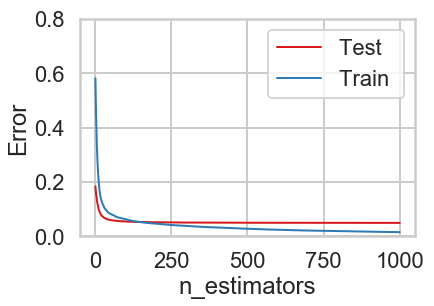

In [69]:
deviance_plot(gb2_cv.best_estimator_, Xtest, ytest, ylim=(0,0.8));
plt.legend();

We are slightly better. Feature importances again:

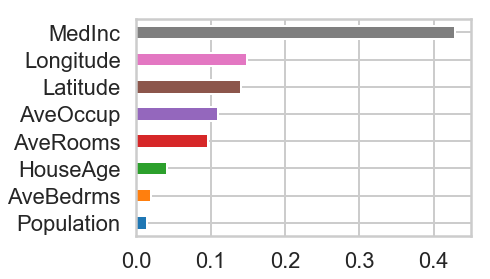

In [70]:
pd.Series(gb2_cv.best_estimator_.feature_importances_, index=names).sort_values().plot(kind="barh")

### Tips:

- ordinal encoding in trees for categorical variables is as effective as one-hot encoding but more efficient, using less memory and being faster. But your trees need to be deeper as you are making more cuts
- often explicit interactions  are useful in GBRT even tho it detects interactions

YOUR TURN NOW

> Repreat the process using the Huber loss and the MAE for scoring